# Chess games data analysis

## Imports

In [1]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
import numpy as np
import os
import urllib
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## Loading the data

The data has been originally sourced from [Kaggle](https://www.kaggle.com/datasnaek/chess) and is hosted on [GitHub](https://github.com/ChrisJMurdoch/ChessGameData) for convenience.

To speed up this part for multiple runs, you can clone the repository to ./data/

In [2]:
LOCAL_SRC = "./data/"
GITHUB_SRC = "https://raw.githubusercontent.com/ChrisJMurdoch/ChessGameData/main/"

In [3]:
try: # Try getting the data locally
    data = pd.read_csv(LOCAL_SRC+"chess_data.csv", index_col=0)
    
except: # Default to GitHub repo
    data = pd.read_csv(GITHUB_SRC+"chess_data.csv", index_col=0)

In [4]:
# Rename some of the lengthier column names
data = data.rename(columns={
    "created_at":"start",
    "last_move_at":"end",
    "victory_status": "status",
    "opening_eco": "eco"
})

## Improving the data

Some useful data can be inferred from existing columns to provide more meaningful results.

### Time and increment

In chess, the time that each player has to make their move is variable.  In the original data, this data is stored as a single string in the form:

 - 10+5 : Each person starts with 10 minutes on their clock, and 5 seconds is added each turn
 - 0+10 : Start with no time on clock, add 10 seconds each turn
 - and so on...

As this does not allow the time and increment values to be recognised as ratio values, we should separate them into columns like so:

In [5]:
data["time"]      = data["increment_code"].apply( lambda code : int(code.split("+")[0])*60 )
data["increment"] = data["increment_code"].apply( lambda code : int(code.split("+")[1]) )

### Start and end times

The columns start and end timestamps should provide good information on when the game was played and how long it lasted.  Unfortunately, the values are stored as floating-point numbers with precision far too low to give meaningful results on duration.  As can be seen below, 43% of the rows report the end time to be exactly the same as the start time.

In [6]:
zero_duration = data["end"] == data["start"]
zero_duration.value_counts(normalize=True)*100

False    57.383588
True     42.616412
dtype: float64

Although we can't get the amount of time the players took to finish the game, we can calculate how much time was available to the players.

Because the time column represents the number of minutes each player has on their clock at the start of the game, and because increment represents the amount of seconds added at the start of their turn, the game's maximum duration can be calculated like so:

In [7]:
data["max_duration"] = (data["time"]*2) + (data["turns"]*data["increment"])
data["max_duration"] = data["max_duration"].clip(upper=20.25*60*60)

Note that the time has been capped at 20.25 hours<sup>1</sup>.  As no player should exceed this time, there is no point in differentiating a player with 21 hours on the clock and one with 100 hours.

<sup>1</sup> [The longest official chess game had 269 moves and lasted 20 hours and 15 minutes.](https://en.wikipedia.org/wiki/List_of_world_records_in_chess)

### Game winner

As winning, drawing and losing in a zero-sum game like chess is easy to quantify, we can change the winner column to a numerical value.  This allows us to calculate the mean winner when aggregating the data.  We can also calculate the difference in ratings into a column so that the difference is preserved when the data is grouped.

In [8]:
data = data.replace({ "winner" : {"white":1, "draw":0, "black":-1} })
data["rating_delta"] = data["white_rating"] - data["black_rating"]

## Cleaning up the data

Before the data is displayed, a few of the unnecessary parts can be removed:


In [9]:
# Drop the columns that aren't needed
data = data.drop([
    'start', 'end',         # These floats are too low-accuracy to provide meaningful results
    'increment_code',       # Replaced by time and increment
    'white_id', 'black_id', # Player names aren't relevant to this analysis
    'moves',                # This data is complex but may be used later
    'opening_name'          # This can be inferred from opening_eco
], axis=1)

# Change to a more intuitive column order
data = data[[
    "rated", "status", "winner",
    "white_rating", "black_rating", "rating_delta",
    "eco", "opening_ply",
    "turns", "time","increment", "max_duration"
]]

### Invalid rows

To ensure that the data works with the neural network, all of the cells must have valid data in them.  Fortunately, as can be seen below, the data set comes with no incomplete or invalid data.

In [10]:
data[data.isnull().any(axis=1)].head()

,rated,status,winner,white_rating,black_rating,rating_delta,eco,opening_ply,turns,time,increment,max_duration
id,,,,,,,,,,,,


## Describing the data

In [11]:
data.head()

,rated,status,winner,white_rating,black_rating,rating_delta,eco,opening_ply,turns,time,increment,max_duration
id,,,,,,,,,,,,
TZJHLljE,False,outoftime,1,1500,1191,309,D10,5,13,900,2,1826
l1NXvwaE,True,resign,-1,1322,1261,61,B00,4,16,300,10,760
mIICvQHh,True,mate,1,1496,1500,-4,C20,3,61,300,10,1210
kWKvrqYL,True,mate,1,1439,1454,-15,D02,3,61,1200,0,2400
9tXo1AUZ,True,mate,1,1523,1469,54,C41,5,95,1800,3,3885


As can be seen above, the data consists of 12 rows:
 - **rated (nominal)**: If the game was ranked by skill
 - **status (nominal)**: If the game was won, drawn, forfeited etc.
 - **winner (ratio)**: Who won the game
 - **white_rating (interval)**: Skill rating of white player
 - **black_rating (interval)**: Skill rating of black player
 - **rating_delta (ratio)**: Difference in skill ratings (white-black)
 - **eco (nominal)**: ECO code for game opening used
 - **opening_ply (ratio)**: How many moves conformed to the opening sequence
 - **turns (ratio)**: How many turns the game lasted
 - **time (ratio)**: How many seconds each player started with on their clock
 - **increment (ratio)**: How many seconds each player gained at the start of their turn
 - **max_duration (ratio)**: The maximum duration the game could have lasted

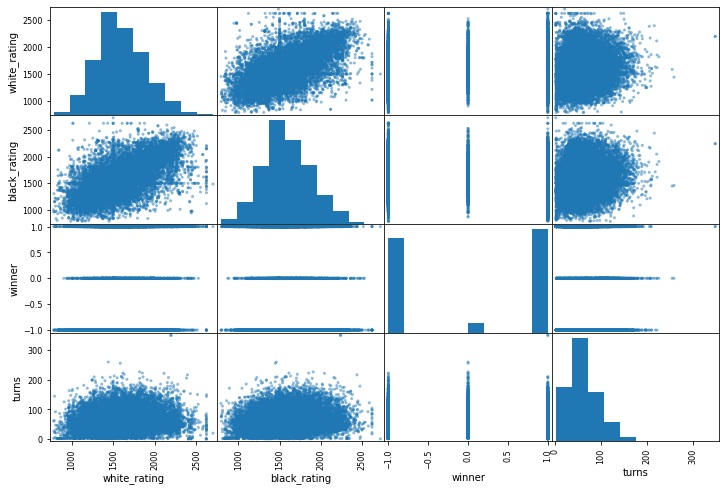

In [12]:
from pandas.plotting import scatter_matrix
attributes = ["white_rating", "black_rating", "winner", "turns"]
scatter_matrix(data[attributes], figsize=(12, 8))
plt.show()

We can see a correlation between white and black ratings as most players are matched with people of similar skill.

It can also be seen that there is a slight positive correlation between player ratings and turns.  After skill ratings of around 2000, few games last less than 30 turns.

### Aggregating the data

By grouping the data by the opening code (ECO), we can see that some openings are a lot more effective than others.

In [13]:
# Create new column to count occurrences
data["unique"] = data.index

# Group by ECO code
grouped = data.groupby('eco').agg({'winner':'mean', 'unique':'size'})

# Filter out the openings with few recorded uses
grouped = grouped[grouped["unique"] > 160]

# Display data sorted by mean win-rate for white
grouped = grouped.sort_values("winner")
grouped

,winner,unique
eco,,
B20,-0.171076,567
A00,-0.170804,1007
A45,-0.126984,252
B30,-0.114537,227
C20,-0.082963,675
B50,-0.066372,226
C50,-0.052045,538
B06,-0.039773,176
D00,-0.025710,739


Because the winner is stored as a ratio, we can find the mean winner of each opening sequence.  This data shows the opening with the highest win rate for white as the popular opening; Queen's Gambit.

<AxesSubplot:xlabel='eco'>

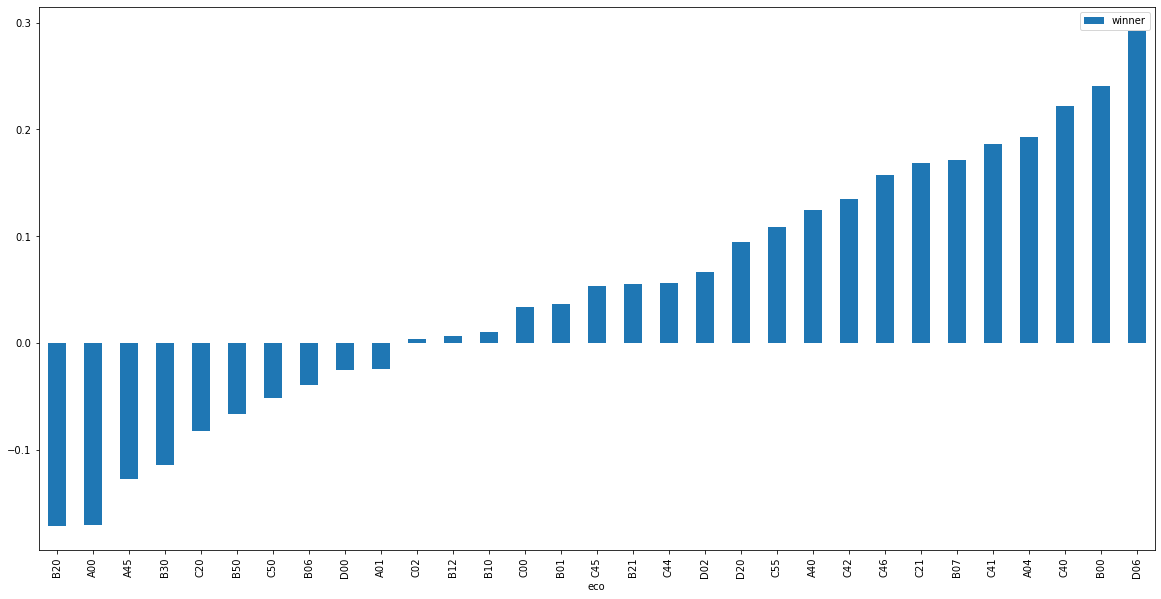

In [14]:
grouped.plot(kind="bar", use_index=True, y='winner', figsize=(20, 10))

Although some openings are more effective than others overall, some will prove to have differing effectiveness depending on the skill level of the user.  Hopefully, the neural network's analysis will reveal what openings are good for players of a certain skill range.